# Estimate the diameter (mm) from the visible masks, using post-processing  techniques (circle fitting and histogram filtering)

In [1]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
from numpy.linalg import inv
import os
import cv2
import random
import tifffile
from pyexcel_ods import get_data
import csv
import json
from tqdm import tqdm
import time
import seaborn as sns
import pandas as pd
import circle_fit as cf

# import some miscellaneous libraries
from utils import visualize
from utils import statistics

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog,MetadataCatalog
from detectron2.engine import DefaultTrainer
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10,10

def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")
    plt.show()

## Register the amodal dataset (so that we can calculate the amodal IoU metric)

In [2]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("broccoli_amodal_test", {}, "datasets/train_val_test_files/orcnn/test/annotations.json", "datasets/train_val_test_files/orcnn/test")

In [3]:
broccoli_amodal_test_metadata = MetadataCatalog.get("broccoli_amodal_test")
print(broccoli_amodal_test_metadata)

Metadata(evaluator_type='coco', image_root='datasets/train_val_test_files/orcnn/test', json_file='datasets/train_val_test_files/orcnn/test/annotations.json', name='broccoli_amodal_test')


In [4]:
dataset_dicts_test = DatasetCatalog.get("broccoli_amodal_test")

[12/14 16:17:09 d2.data.datasets.coco]: Loaded 487 images in COCO format from datasets/train_val_test_files/orcnn/test/annotations.json


## Initialize the image inference

In [5]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (broccoli)

cfg.OUTPUT_DIR = "weights/20201010_broccoli_visible"
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0008999.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.01
cfg.DATASETS.TEST = ("broccoli_amodal_test",)

predictor = DefaultPredictor(cfg)

## Circle fit on the contour of the visible mask

In [6]:
def fit_circle(masks):
    masks = masks.astype(np.uint8)

    if masks.any():
        maskstransposed = masks.transpose(1,2,0) # transform the mask in the same format as the input image array (h,w,num_dets)
        cXs = np.zeros(maskstransposed.shape[-1],dtype=np.uint16)
        cYs = np.zeros(maskstransposed.shape[-1],dtype=np.uint16)
        diameters = np.zeros(maskstransposed.shape[-1],dtype=np.float32)

        for i in range (maskstransposed.shape[-1]):
            masksel = maskstransposed[:,:,i] # select the individual masks
            contours, hierarchy = cv2.findContours((masksel*255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            cnt = np.concatenate(contours)
            (x,y),r1 = cv2.minEnclosingCircle(cnt)
            
            # convex hull
            uni_hull = []
            hull = cv2.convexHull(cnt)
            uni_hull.append(hull)
            hull_points = uni_hull[0].reshape((uni_hull[0].shape[0],2))
            
            # hyper least squares fitting (https://doi.org/10.1016/j.csda.2010.12.012)
            x, y, r2, s = cf.hyper_fit(hull_points)
            r = np.maximum(r1, r2)
            
            cXs[i] = int(x)
            cYs[i] = int(y)
            diameters[i] = r*2

    else:
        cXs = 0
        cYs = 0
        diameters = 0

    return cXs, cYs, diameters

## Histogram filtering on the depth channel of the XYZ image

In [7]:
def histogram_filtering(xyzimg, masks, max_depth_range_broc=100, max_depth_contribution=0.04):
    masks = masks.astype(np.uint8)
    
    if len(xyzimg.shape) == 3:
        z = np.expand_dims(xyzimg[:,:,-1], axis=2)
    else:
        z = np.expand_dims(xyzimg, axis=2)

    if masks.any():
        md, mh, mw = masks.shape
        masks_final = np.zeros((md,mh,mw),dtype=np.uint8)
        maskstransposed = masks.transpose(1,2,0) 
        zts = np.zeros(maskstransposed.shape[-1])
        zes = np.zeros(maskstransposed.shape[-1])

        for i in range (maskstransposed.shape[-1]):
            masksel = maskstransposed[:,:,i]                  
            masksel_bool = masksel.astype(np.bool)

            z_mask = z[masksel_bool]
            z_mask_filtered = z_mask[z_mask != 0]

            if z_mask_filtered.size > 1: 
                z_mask_filtered_range = np.max(z_mask_filtered)-np.min(z_mask_filtered)

                if (z_mask_filtered_range > max_depth_range_broc):
                    hist, bin_edges = np.histogram(z_mask_filtered, density=False)
                    hist_peak = np.argmax(hist)
                    lb = bin_edges[hist_peak]
                    ub = bin_edges[hist_peak+1]

                    bc = np.bincount(np.absolute(z_mask_filtered.astype(np.int64)))
                    peak_id = np.argmax(bc)

                    if peak_id > int(lb) and peak_id < int(ub):
                        peak_id = peak_id
                    else:
                        bc_clip = bc[int(lb):int(ub)]
                        peak_id = int(lb) + np.argmax(bc_clip)

                    pixel_counts = np.zeros((10), dtype=np.int64)

                    for j in range(10):
                        lower_bound = peak_id-(max_depth_range_broc - (j * 10))
                        upper_bound = lower_bound + max_depth_range_broc
                        z_final = z_mask_filtered[np.where(np.logical_and(z_mask_filtered >= lower_bound, z_mask_filtered <= upper_bound))]
                        pixel_counts[j] = z_final.size

                    pix_id = np.argmax(pixel_counts)
                    lower_bound = peak_id-(max_depth_range_broc - (pix_id * 10))
                    upper_bound = lower_bound + max_depth_range_broc
                    z_final = z_mask_filtered[np.where(np.logical_and(z_mask_filtered >= lower_bound, z_mask_filtered <= upper_bound))]

                    hist_f, bin_edges_f = np.histogram(z_final, density=False)
                    norm1 = hist_f / np.sum(hist_f)

                else:
                    hist_f, bin_edges_f = np.histogram(z_mask_filtered, density=False)
                    norm1 = hist_f / np.sum(hist_f)

                sel1 = bin_edges_f[np.where(norm1 >= max_depth_contribution)]
                sel2 = bin_edges_f[np.where(norm1 >= max_depth_contribution)[0]+1]
                edges = np.concatenate((sel1,sel2), axis=0)
                final_bins = np.unique(edges)

                z_top = np.min(final_bins)
                z_edge = np.max(final_bins)

                zts[i] = z_top
                zes[i] = z_edge
            else:
                zts[i] = 0
                zes[i] = 0

    else:
        zts = 0
        zes = 0

    return z, zts, zes

## Extract the pixel-to-mm ratio

In [8]:
def pixel_to_mm(xyzimg, boxes, masks, zes, intrinsicsfile):
    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]

    
    # Python implementation of rs2_deproject_pixel_to_point
    def pixel_to_point(intrinsics, pixel, depth):
        with open(intrinsics) as json_file:
            intrinsics = json.load(json_file)
        
        x = (pixel[0] - intrinsics['ppx']) / intrinsics['fx']
        y = (pixel[1] - intrinsics['ppy']) / intrinsics['fy']

        r2 = x*x + y*y
        f = 1 + intrinsics['coeffs'][0]*r2 + intrinsics['coeffs'][1]*r2*r2 + intrinsics['coeffs'][4]*r2*r2*r2
        ux = x*f + 2*intrinsics['coeffs'][2]*x*y + intrinsics['coeffs'][3]*(r2 + 2*x*x)
        uy = y*f + 2*intrinsics['coeffs'][3]*x*y + intrinsics['coeffs'][2]*(r2 + 2*y*y)
        return(np.asarray([depth * ux, depth* uy, depth]))
    

    if masks.any():
        maskstransposed = masks.transpose(1,2,0)
        pixel_to_mm_ratios = np.zeros(maskstransposed.shape[-1],dtype=np.float32)  

        for i in range (maskstransposed.shape[-1]):
            masksel = np.expand_dims(maskstransposed[:,:,i],axis=2).astype(np.uint8) # select the individual masks
            bbox = boxes[i].astype(np.uint16)
            masksel = masksel[bbox[1]:bbox[3],bbox[0]:bbox[2]] # crop the mask to the boxing box to reduce memory load
                
            if len(xyzimg.shape) == 3:
                xyz_mask = xyzimg[bbox[1]:bbox[3],bbox[0]:bbox[2]]
                xyz_mask = np.multiply(xyz_mask,masksel)
                z = xyz_mask[:,:,2]
            else:
                zimg = xyzimg
                z_mask = zimg[bbox[1]:bbox[3],bbox[0]:bbox[2]]
                z_mask = np.multiply(np.expand_dims(z_mask, axis=2),masksel)
                z = z_mask

            ze = zes[i]
            zflat = z.flatten()

            if ze > 0:
                z_edge = find_nearest(zflat, ze)
                
                # Procedure when using an XYZ image
                if len(xyzimg.shape) == 3:
                    xyz_edge = np.where(xyz_mask == z_edge)
                    attempts = 0

                    while len(xyz_edge[0]) < 2:
                        z_edge_prev = z_edge
                        zflat = zflat[zflat != z_edge_prev]
                        z_edge = find_nearest(zflat, z_edge_prev)
                        xyz_edge = np.where(xyz_mask == z_edge)
                        attempts = attempts+1

                        if int(attempts) > 10:
                            zflat = z.flatten()
                            z_edge = find_nearest(zflat, ze)
                            xyz_edge = np.where(xyz_mask == z_edge)
                            break

                    x1_edge = xyz_edge[0][0]
                    y1_edge = xyz_edge[1][0]

                    pixel1 = np.asarray((x1_edge, y1_edge))
                    xyz1 = xyz_mask[x1_edge, y1_edge,:]

                    if len(xyz_edge[0]) >= 2:
                        x2_edge = xyz_edge[0][1]
                        y2_edge = xyz_edge[1][1]

                        pixel2 = np.asarray((x2_edge, y2_edge))
                        xyz2 = xyz_mask[x2_edge, y2_edge, :]

                    else:
                        z_edge_new = find_nearest(zflat[zflat != z_edge], z_edge)
                        xyz_edge_new = np.where(xyz_mask == z_edge_new)

                        x2_edge = xyz_edge_new[0][0]
                        y2_edge = xyz_edge_new[1][0]

                        pixel2 = np.asarray((x2_edge, y2_edge))
                        xyz2 = xyz_mask[x2_edge, y2_edge, :]
                        xyz2[2] = z_edge                

                    dist_pixel = np.linalg.norm(pixel1-pixel2)
                    dist_mm = np.linalg.norm(xyz1-xyz2)
                    pixel_to_mm_ratios[i] = np.divide(dist_pixel, dist_mm)
                    
                # Procedure when using the depth image from the Realsense
                else:
                    xyz_edge = np.where(z_mask == z_edge)
                    x1_edge = xyz_edge[0][0]
                    y1_edge = xyz_edge[1][0]

                    xyz1 = pixel_to_point(intrinsicsfile, [x1_edge, y1_edge], z_edge)
                    xyz2 = pixel_to_point(intrinsicsfile, [x1_edge+1, y1_edge], z_edge)

                    pixel1 = np.asarray((x1_edge, y1_edge))
                    pixel2 = np.asarray((x1_edge+1, y1_edge))

                    dist_pixel = np.linalg.norm(pixel1-pixel2)
                    dist_mm = np.linalg.norm(xyz1-xyz2)
                    pixel_to_mm_ratios[i] = np.divide(dist_pixel, dist_mm)

    else:
        pixel_to_mm_ratios=0

    return pixel_to_mm_ratios

## Estimate the real-world diameter (mm) from the visible masks, using post-processing  techniques (circle fitting and histogram filtering)

In [9]:
# User input needed (directory, file locations, etc):
analysis_name = "mrcnn_postprocessing"
xyzimgdir = "./datasets/train_val_test_files/regression/test"
gtfile = "./datasets/train_val_test_files/groundtruth_measurements_broccoli.ods" ## comment out if there is no ground truth file (also restart the kernel)
intrinsicsfile = "./datasets/train_val_test_files/depth_intrin.json"

100%|██████████| 487/487 [02:09<00:00,  3.76it/s]


201_Untrimmed_Frame_10_119_rgb.png


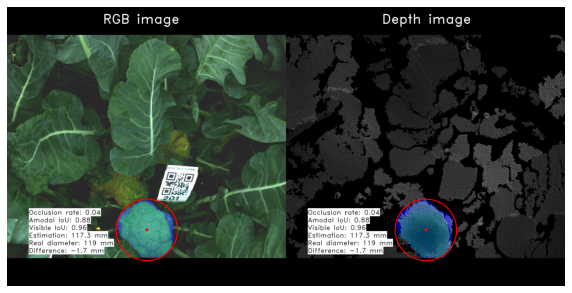

20200713_105309998405_plant1013_rgb_trigger010.png


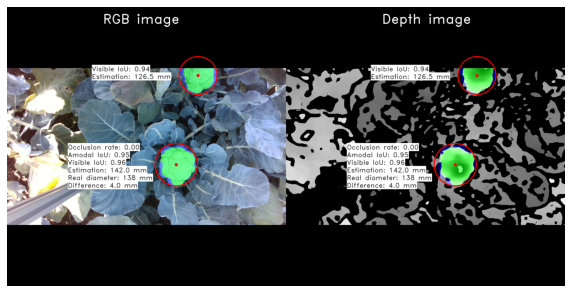

20200713_151427103812_plant1078_rgb_trigger004.png


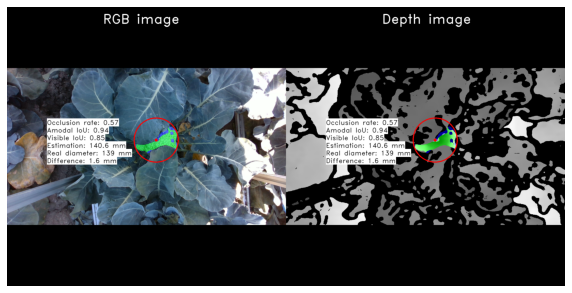

20200713_172203791944_plant1113_rgb_trigger019.png


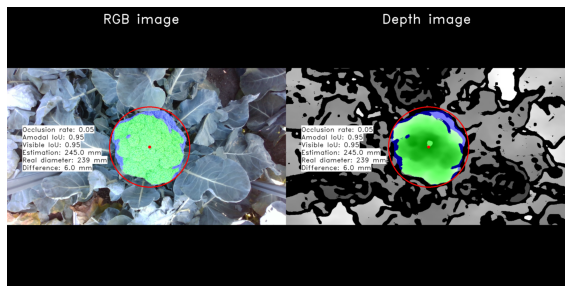

20200819_093651151923_plant1135_rgb_trigger012.png


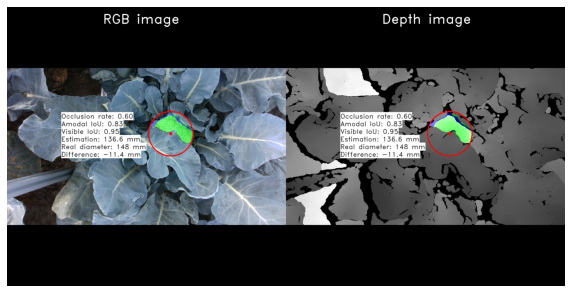

20200819_095152244183_plant1138_rgb_trigger031.png


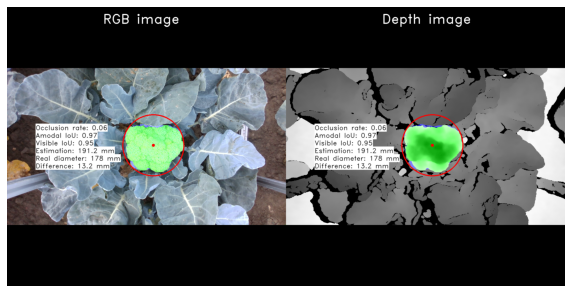

20200819_115616932930_plant1170_rgb_trigger015.png


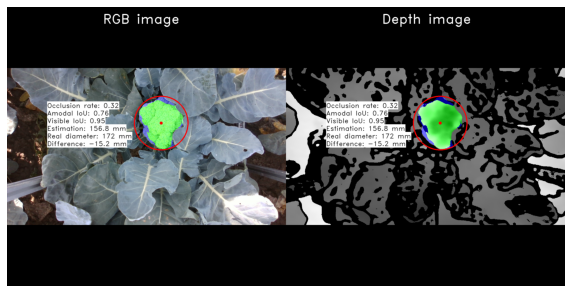

20200819_142107655050_plant1182_rgb_trigger008.png


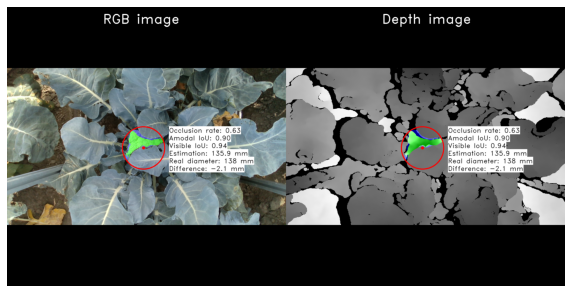

20200819_14491273592_plant1193_rgb_trigger009.png


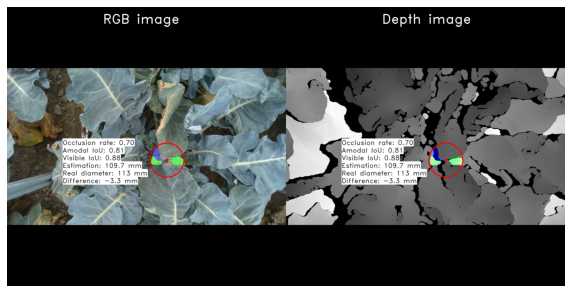

220_Untrimmed_Frame_7_141_rgb.png


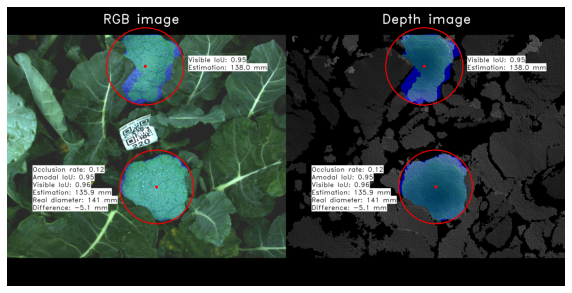

In [10]:
writedir = os.path.join("./results", analysis_name)

if not os.path.exists(writedir):
    os.makedirs(writedir)

try:
    gt = get_data(gtfile)
    gt_file_present = True
except:
    gt_file_present = False

csv_name = 'results_' + analysis_name + '.csv'
with open(os.path.join(writedir, csv_name), 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
    csvwriter.writerow(['image_id', 'number of detections', 'amodal IoU', 'visible IoU', 'diameter estimation (mm)', 'real-world diameter (mm)', 'difference in diameter (mm)', 'occlusion rate', 'image analysis time CNN (s)', 'image analysis time circle-fit (s)', 'image analysis time histogram filtering (s)', 'image analysis time pixel/mm conversion (s)'])

ious = []
diffs = []
vprs = []
gtsizes = []
inference_times_cnn = []
inference_times_circle_fit = []
inference_times_hist_filter = []
inference_times_pixelmm = []

ids_visualize = np.random.choice(np.arange(len(dataset_dicts_test)), 10)
random_images = []
random_imagenames = []

for i in tqdm(range(len(dataset_dicts_test))):
    # Load the RGB image
    imgname = dataset_dicts_test[i]["file_name"]
    basename = os.path.basename(imgname)
    img = cv2.imread(imgname)


    # Load the XYZ image or the depth image
    try:
        xyzimgname = basename.replace("rgb", "xyz")
        xyzimgname = xyzimgname.replace(".png", ".tiff")
        xyzimg = tifffile.imread(os.path.join(xyzimgdir, xyzimgname))
    except:
        depthimgname = basename.replace("rgb", "depth")
        xyzimg = cv2.imread(os.path.join(xyzimgdir, depthimgname), -1)


    # Do the image inference and extract the outputs from Mask R-CNN
    start_time = time.time()
    outputs = predictor(img)
    instances = outputs["instances"].to("cpu")
    classes = instances.pred_classes.numpy()
    scores = instances.scores.numpy()
    boxes = instances.pred_boxes.tensor.numpy()
    try:
        detection_num = len(boxes)
    except:
        detection_num = 0


    # Procedure to check whether we are dealing with ORCNN or MRCNN
    if "pred_visible_masks" in instances._fields:
        amodal_masks = instances.pred_masks.numpy()
        visible_masks = instances.pred_visible_masks.numpy()
    else:
        visible_masks = instances.pred_masks.numpy()
    end_time = time.time()
    elapsed_time_cnn = end_time-start_time
    inference_times_cnn.append(elapsed_time_cnn)


    # Procedure to load the annotations (to calculate the amodal and the visible IoU)
    d = dataset_dicts_test[i]
    classes_annot = []
    amodal_masks_poly = []
    visible_masks_poly = []
    for k in range(len(d["annotations"])):
        classes_annot.append(d["annotations"][k]['category_id'])
        amodal_masks_poly.append(d["annotations"][k]['segmentation'])
        visible_masks_poly.append(d["annotations"][k]['visible_mask'])


    # Circle fit
    start_time = time.time()
    if "pred_visible_masks" in instances._fields:
        cXs, cYs, diameters_pixel = fit_circle(amodal_masks)
    else:
        cXs, cYs, diameters_pixel = fit_circle(visible_masks)
    end_time = time.time()
    elapsed_time_cf = end_time-start_time
    inference_times_circle_fit.append(elapsed_time_cf)


    # Calculate the amodal IoU    
    amodal_masks_annot = visualize.make_mask_img(amodal_masks_poly, d['height'], d['width'], "polylines")
    amodal_circle = visualize.make_mask_img([cXs,cYs,diameters_pixel], d['height'], d['width'], "circle")
    iou_amodal = statistics.calculate_iou(amodal_masks_annot, amodal_circle, np.array(classes_annot), classes)
    max_iou_amodal = np.amax(iou_amodal, axis=0)


    # Calculate the visible IoU    
    visible_masks_annot = visualize.make_mask_img(visible_masks_poly, d['height'], d['width'], "polylines")
    iou_visible = statistics.calculate_iou(visible_masks_annot, visible_masks, np.array(classes_annot), classes)
    max_iou_visible = np.amax(iou_visible, axis=0)


    # Do the histogram filtering on the Z-image (depth image)
    start_time = time.time()
    zimg, zts, zes = histogram_filtering(xyzimg, visible_masks, 100, 0.04)
    end_time = time.time()
    elapsed_time_hf = end_time-start_time
    inference_times_hist_filter.append(elapsed_time_hf)


    # Extract the pixel to mm factor
    start_time = time.time()
    pixel_to_mm_ratios = pixel_to_mm(xyzimg, boxes, visible_masks, zes, intrinsicsfile)
    diameters_mm = np.divide(diameters_pixel, pixel_to_mm_ratios)
    end_time = time.time()
    elapsed_time_pm = end_time-start_time
    inference_times_pixelmm.append(elapsed_time_pm)


    # Get the ground truth data
    real_diameter = 0
    visible_pixel_ratio = 0
    gt_data_present = False

    if gt_file_present:
        for k in range(1, len(gt['groundtruth_measurements_broccoli'])):
            gt_data = gt['groundtruth_measurements_broccoli'][k]
            if gt_data:
                if gt_data[0] == basename:
                    gt_data_present = True
                    plant_id = gt_data[1]
                    real_diameter = gt_data[2]
                    x_center_gt = gt_data[3]
                    y_center_gt = gt_data[4]
                    visible_pixel_ratio = float(gt_data[5])
                    occlusion_rate = float(1-visible_pixel_ratio)
                    coordinates_broccoli_gt = (x_center_gt, y_center_gt)


    # Find the broccoli head that belongs to the ground truth data
    distances = []
    if np.logical_and(boxes.size > 0, gt_data_present):
        for h in range(len(boxes)):
            box = boxes[h]
            x_center = box[0] + ((box[2] - box[0]) / 2)
            y_center = box[1] + ((box[3] - box[1]) / 2)
            distances.append(np.linalg.norm(np.asarray(coordinates_broccoli_gt) - np.asarray((x_center, y_center))))

        idx = np.asarray(distances).argmin()
        diameter = diameters_mm[idx]
        amodal_IoU = max_iou_amodal[idx]
        visible_IoU = max_iou_visible[idx]
    else:
        idx = []
        diameter = np.nan
        amodal_IoU = np.nan
        visible_IoU = np.nan


    # Visualize the results and store them in the output folder
    img_output, zimg_output = visualize.visualize_results(img, zimg, boxes, visible_masks, np.array([]), zts, zes, cXs, cYs, diameters_pixel, diameters_mm, idx, str(real_diameter), occlusion_rate, amodal_IoU, max_iou_visible)
    img_mosaic = np.hstack((img_output, zimg_output))
    cv2.imwrite(os.path.join(writedir, basename), img_mosaic)


    # Store the randomly selected images in an array    
    if i in ids_visualize:
        random_imagenames.append(basename)
        random_images.append(img_mosaic)


    # Store the results
    if gt_data_present:
        with open(os.path.join(writedir, csv_name), 'a', newline='') as csvfile:
            csvwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
            csvwriter.writerow([xyzimgname, detection_num, round(amodal_IoU, 3), round(visible_IoU, 3), round(diameter, 1), round(real_diameter, 1), round(np.subtract(diameter, real_diameter), 1), round(occlusion_rate, 3), round(elapsed_time_cnn, 4), round(elapsed_time_cf, 4), round(elapsed_time_hf, 4), round(elapsed_time_pm, 4)])

        ious.append(float(amodal_IoU))
        diffs.append(float(np.subtract(diameter, real_diameter)))
        vprs.append(float(visible_pixel_ratio))
        gtsizes.append(float(real_diameter))
        
        
# Visualize the results
for j in range(len(random_images)):
    image_name = random_imagenames[j]
    print(image_name)
    image = random_images[j]
    imshow(image)

## Summary statistics and graph plotting

Average error when sizing 487 broccoli heads: 10.7 mm
Biggest error when sizing 487 broccoli heads: 123.1 mm


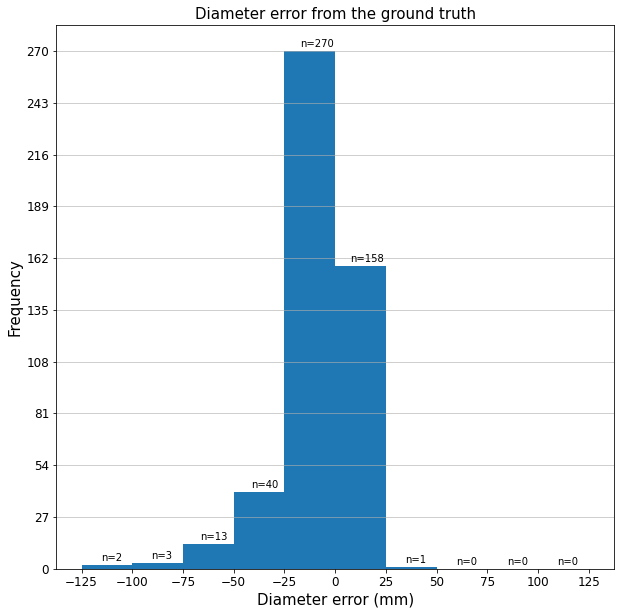

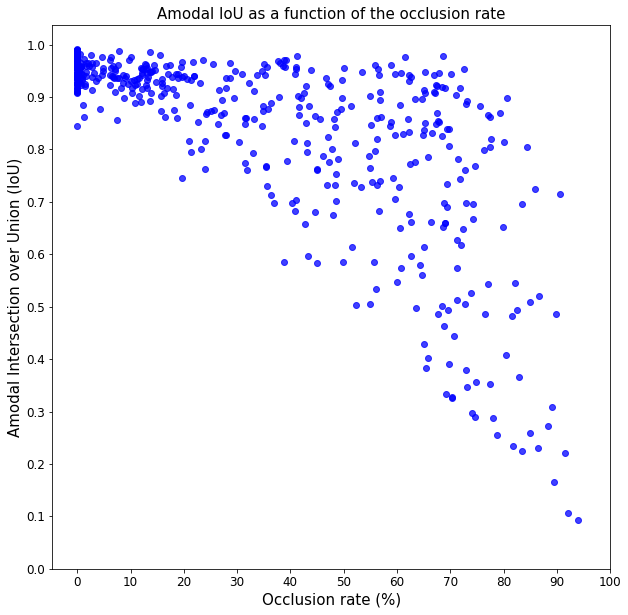

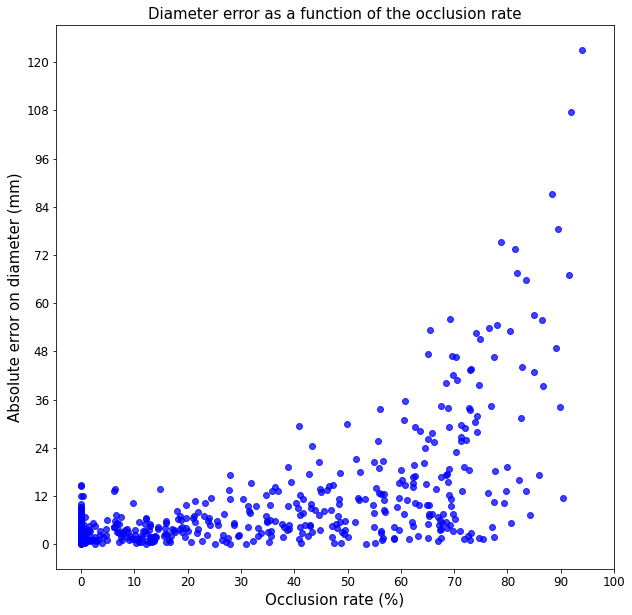

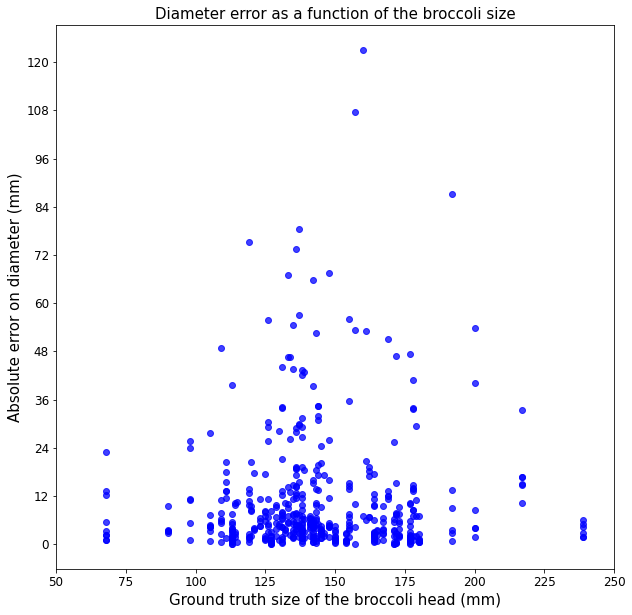

Average image analysis time when sizing 487 broccoli heads: 0.14 s
Highest image analysis time when sizing 487 broccoli heads: 0.24 s


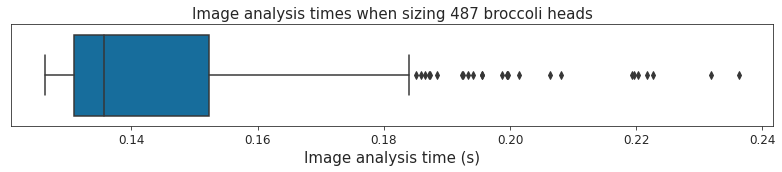

In [11]:
if diffs:
    np.set_printoptions(formatter={'float_kind':'{:f}'.format})

    print("Average error when sizing {0:.0f} broccoli heads: {1:.1f} mm".format(len(dataset_dicts_test), np.average(np.abs(diffs))))
    print("Biggest error when sizing {0:.0f} broccoli heads: {1:.1f} mm".format(len(dataset_dicts_test), np.max(np.abs(diffs))))

    digit_size = 12
    text_size = 15    

    min_bin = statistics.ceil_to_25(-np.max(np.abs(diffs)))
    max_bin = statistics.ceil_to_25(np.max(np.abs(diffs)))
    bin_range = np.abs(max_bin - min_bin)
    
    # Plot the diameter error in a histogram
    statistics.histogram_error(diffs, min_bin, max_bin, bin_range, digit_size, text_size)
    
    
    # Plot the amodal IoU as a function of the occlusion rate (scatter plot)
    statistics.scatterplot_iou(ious, vprs, max_bin, digit_size, text_size)
    
    
    # Plot the diameter error as a function of the occlusion rate (scatter plot)
    statistics.scatterplot_occlusion(diffs, vprs, max_bin, digit_size, text_size)
    

    # Plot the diameter error as a function of the broccoli size (scatter plot)
    statistics.scatterplot_size(diffs, gtsizes, max_bin, digit_size, text_size)
    
    inference_times = []
    for i in range(len(inference_times_cnn)):
        inference_times.append((inference_times_cnn[i] + inference_times_circle_fit[i] + inference_times_hist_filter[i] + inference_times_pixelmm[i]))
    
    print("Average image analysis time when sizing {0:.0f} broccoli heads: {1:.2f} s".format(len(dataset_dicts_test), np.average(inference_times)))
    print("Highest image analysis time when sizing {0:.0f} broccoli heads: {1:.2f} s".format(len(dataset_dicts_test), np.max(inference_times)))
    
    # Plot the inferences times in a boxplot
    statistics.boxplot_time(len(dataset_dicts_test), inference_times, digit_size, text_size)